# Initial setup

In [1]:
import os
import numpy as np
import seaborn as sns
from scipy import stats
from getpass import getpass
from dotenv import load_dotenv
import matplotlib.pyplot as plt

import wandb
import torch
import pytorch_lightning as pl
from sklearn.model_selection import KFold, train_test_split

from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

from models import CNNClassifier, MatrixDataset, get_feature_maps

# Load and inspect data

In [2]:
# Load data
data_path = "../data/"
all_C = np.load(data_path + 'all_C.npy') # 1329 input matrices of size 30x30
nMF_label = np.load(data_path + 'nMF_label.npy') # 1329 output labels (0 or 1)

class_0_C = all_C[nMF_label == 0] # input matrices of size 30x30 with nMF label 0
class_1_C = all_C[nMF_label == 1] # input matrices of size 30x30 with nMF label 1

# print some stats
print(f"Number of input matrices with nMF label 0: {class_0_C.shape[0]}")
print(f"Number of input matrices with nMF label 1: {class_1_C.shape[0]}")

Number of input matrices with nMF label 0: 574
Number of input matrices with nMF label 1: 755


In [3]:
# Check the normality of the data
non_normal_indices = []

# Test each matrix individually
for i in range(len(all_C)):
    # Flatten current matrix
    matrix_flat = all_C[i].flatten()
    
    # Perform normality test
    _, p_value = stats.normaltest(matrix_flat)
    
    # If p-value <= 0.05, the distribution is not normal
    if p_value <= 0.05:
        non_normal_indices.append(i)

# Print results
if len(non_normal_indices) == 0:
    print("Normality check passed: All matrices are normally distributed")
else:
    print(f"Normality check failed: {len(non_normal_indices)} out of {len(all_C)} matrices are not normally distributed")

Normality check failed: 1328 out of 1329 matrices are not normally distributed


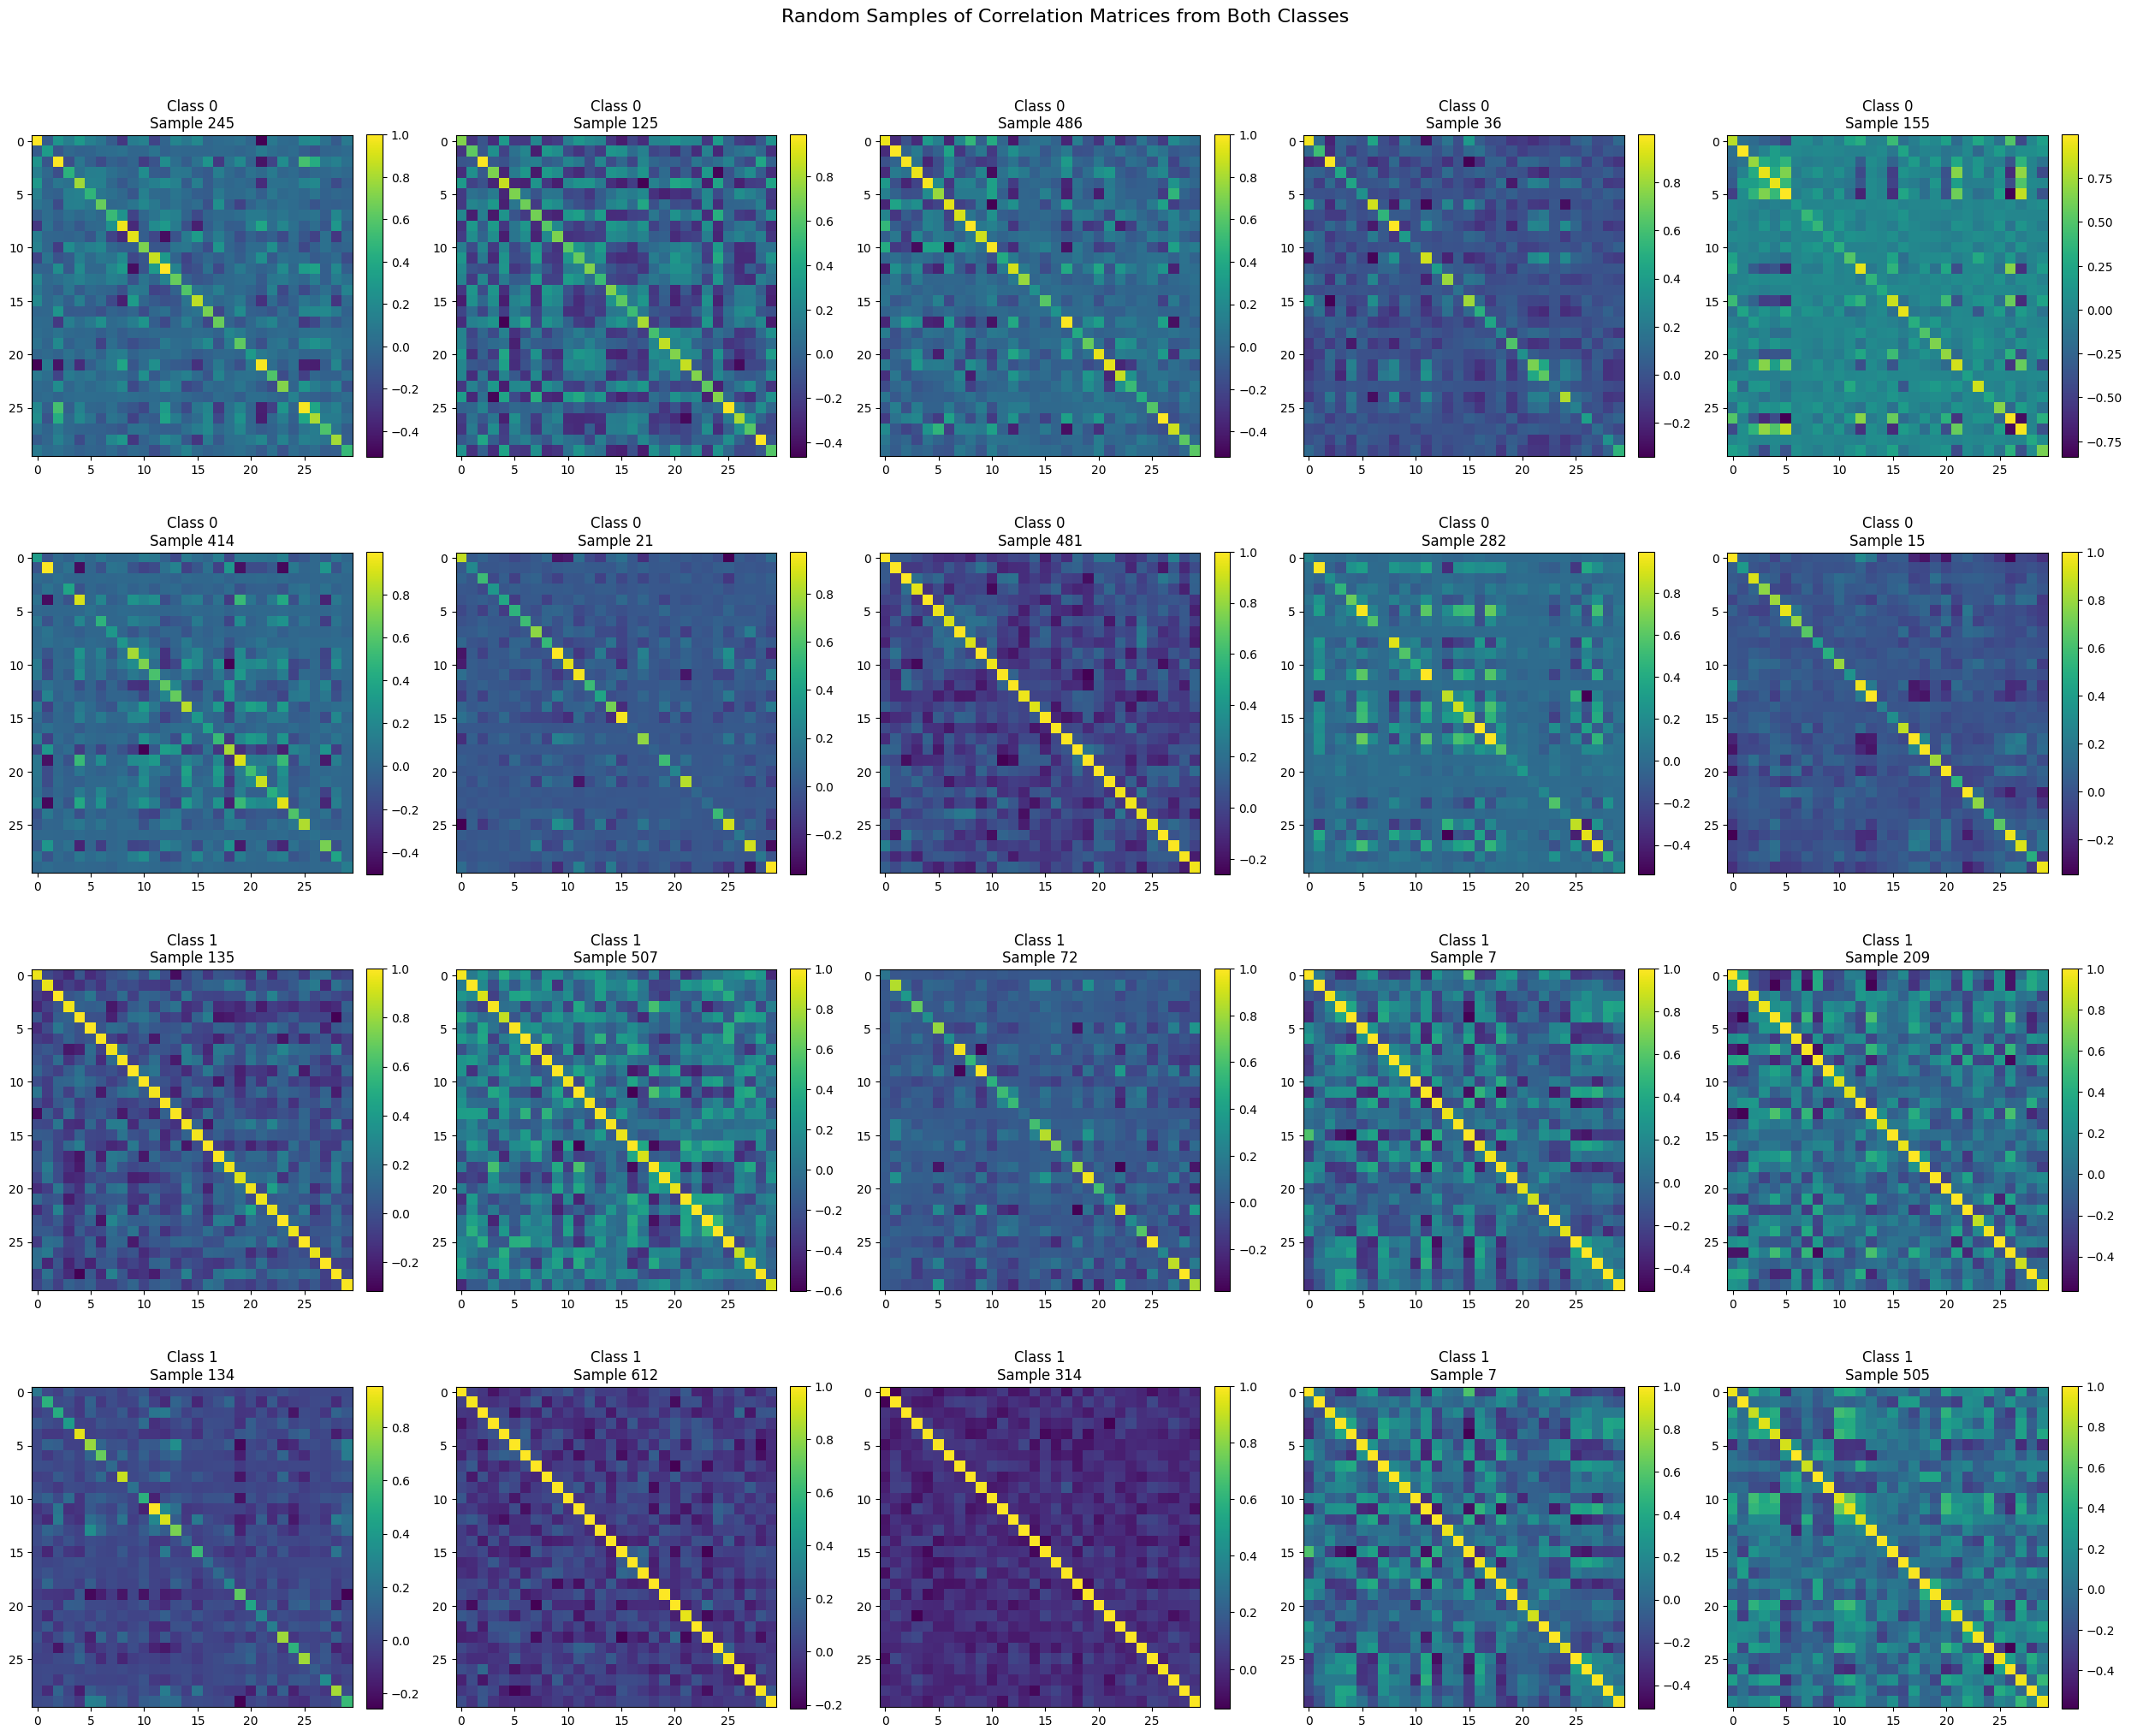

In [4]:
# Inspect the matrices
plt.figure(figsize=(25, 20))

# Plot 10 random matrices from class 0 
for i in range(10):
    row = i // 5  # 0 for first 5 items, 1 for next 5
    col = i % 5   # 0-4 for each row
    plt.subplot(4, 5, row*5 + col + 1)
    random_idx = np.random.randint(0, len(class_0_C))
    im = plt.imshow(class_0_C[random_idx], cmap='viridis')
    plt.title(f'Class 0\nSample {random_idx}')
    plt.colorbar(im, fraction=0.046, pad=0.04)

# Plot 10 random matrices from class 1 
for i in range(10):
    row = i // 5  # 0 for first 5 items, 1 for next 5
    col = i % 5   # 0-4 for each row
    plt.subplot(4, 5, (row+2)*5 + col + 1)  # +2 to start from third row
    random_idx = np.random.randint(0, len(class_1_C))
    im = plt.imshow(class_1_C[random_idx], cmap='viridis')
    plt.title(f'Class 1\nSample {random_idx}')
    plt.colorbar(im, fraction=0.046, pad=0.04)

# Add a main title
plt.suptitle('Random Samples of Correlation Matrices from Both Classes', 
             fontsize=16, y=1.02)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

/var/folders/rz/xbbk13895bx876fqwb2x4v540000gn/T/ipykernel_2490/3946232156.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mins, maxs], labels=['Min Values', 'Max Values'])
/var/folders/rz/xbbk13895bx876fqwb2x4v540000gn/T/ipykernel_2490/3946232156.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([class_mins, class_maxs], labels=['Min Values', 'Max Values'])
/var/folders/rz/xbbk13895bx876fqwb2x4v540000gn/T/ipykernel_2490/3946232156.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([class_mins, class_maxs], labels=['Min Values', 'Max Values'])


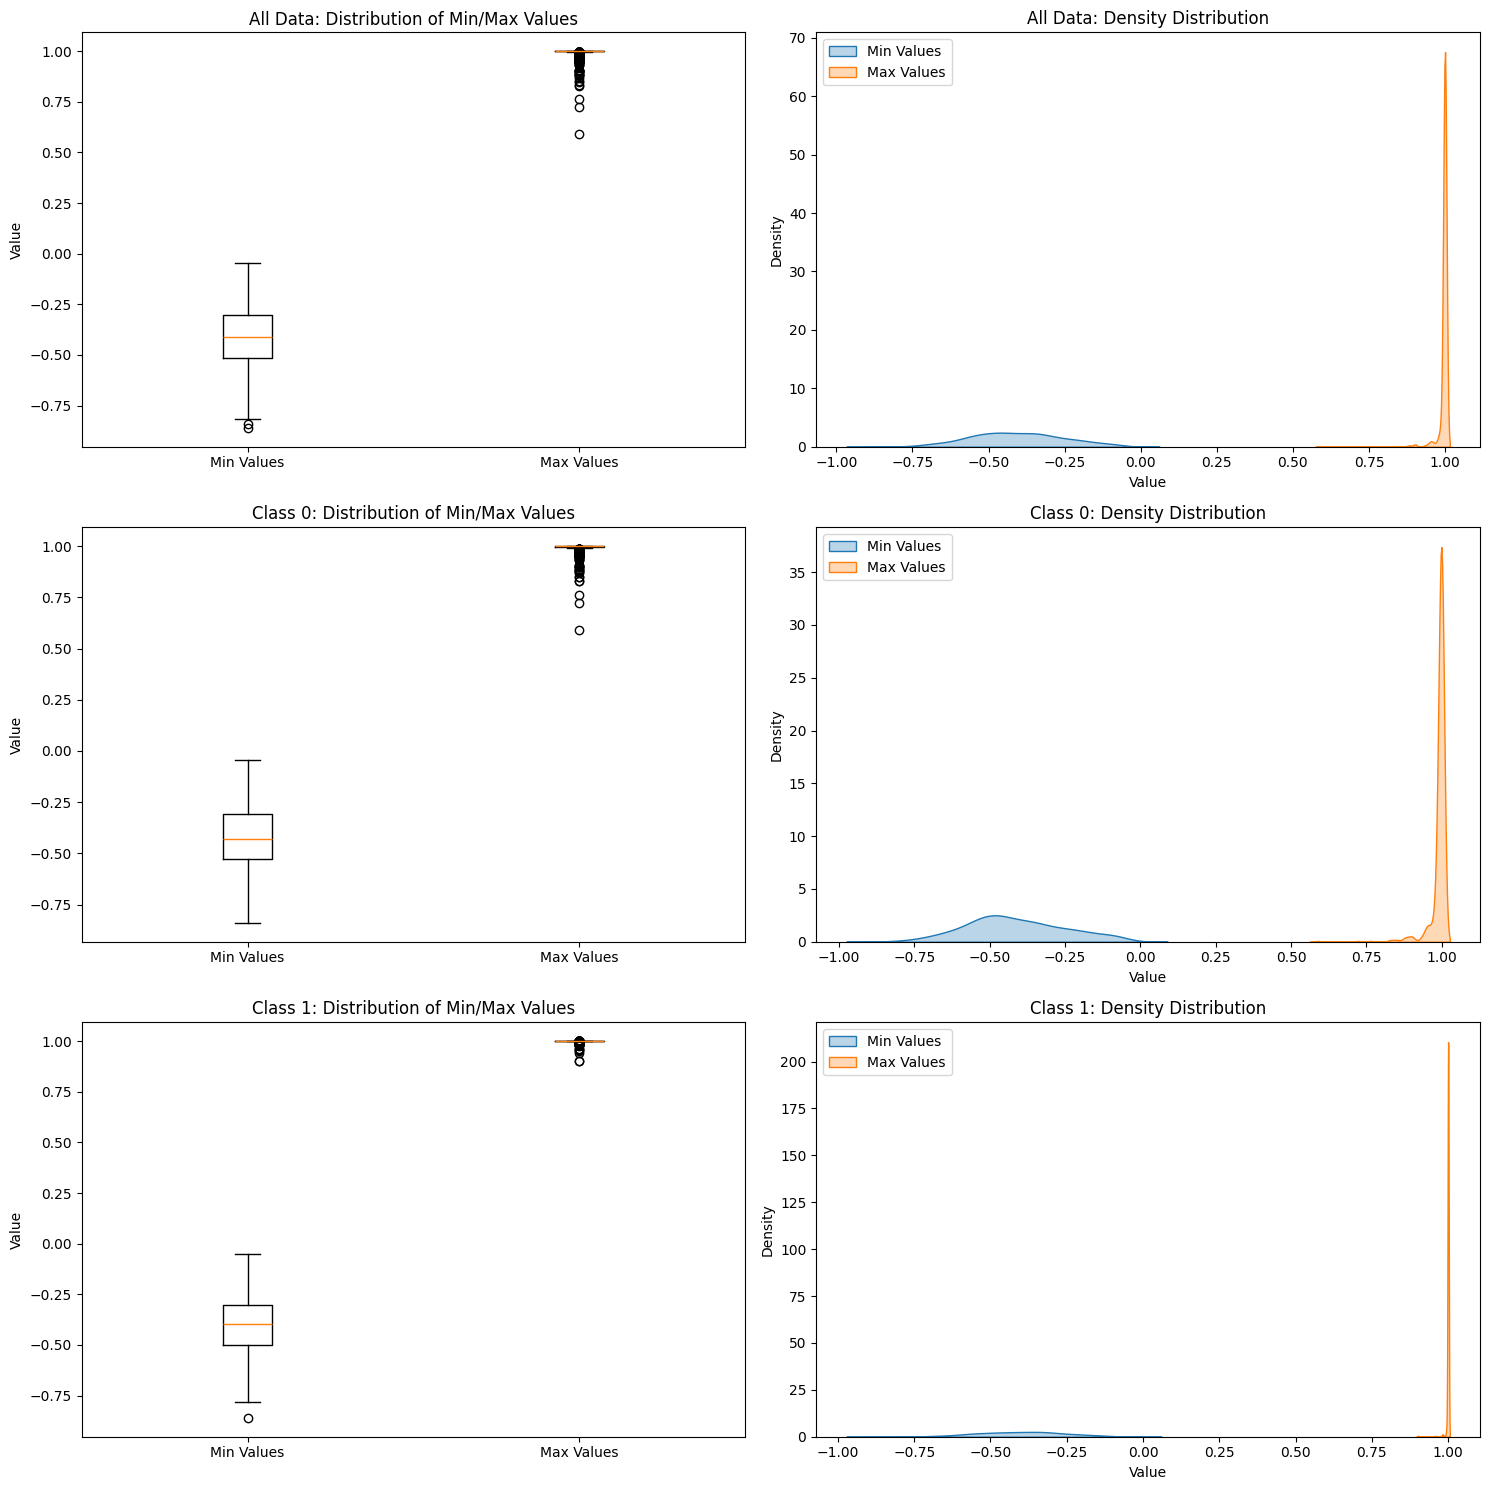

Overall Statistics:

Minimum values:
Mean: -0.4056, Std: 0.1502
Range: [-0.8604, -0.0451]

Maximum values:
Mean: 0.9952, Std: 0.0219
Range: [0.5892, 1.0001]

Class 0 Statistics:
Number of samples: 574

Minimum values:
Mean: -0.4131, Std: 0.1615
Range: [-0.8393, -0.0451]

Maximum values:
Mean: 0.9902, Std: 0.0318
Range: [0.5892, 1.0001]

Class 1 Statistics:
Number of samples: 755

Minimum values:
Mean: -0.3999, Std: 0.1407
Range: [-0.8604, -0.0514]

Maximum values:
Mean: 0.9990, Std: 0.0066
Range: [0.9004, 1.0001]


In [5]:
# Calculate min and max for each matrix
mins = np.array([matrix.min() for matrix in all_C])
maxs = np.array([matrix.max() for matrix in all_C])

plt.figure(figsize=(15, 15))

# Plot of all data
plt.subplot(321)
plt.boxplot([mins, maxs], labels=['Min Values', 'Max Values'])
plt.title('All Data: Distribution of Min/Max Values')
plt.ylabel('Value')

plt.subplot(322)
sns.kdeplot(data=mins, label='Min Values', fill=True, alpha=0.3)
sns.kdeplot(data=maxs, label='Max Values', fill=True, alpha=0.3)
plt.title('All Data: Density Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Plots for each class
for idx, class_label in enumerate([0, 1]):
    class_indices = np.where(nMF_label == class_label)[0]
    class_mins = mins[class_indices]
    class_maxs = maxs[class_indices]
    
    # Box plot for class
    plt.subplot(323 + idx*2)
    plt.boxplot([class_mins, class_maxs], labels=['Min Values', 'Max Values'])
    plt.title(f'Class {class_label}: Distribution of Min/Max Values')
    plt.ylabel('Value')
    
    # Density plot for class
    plt.subplot(324 + idx*2)
    sns.kdeplot(data=class_mins, label='Min Values', fill=True, alpha=0.3)
    sns.kdeplot(data=class_maxs, label='Max Values', fill=True, alpha=0.3)
    plt.title(f'Class {class_label}: Density Distribution')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()

# Print statistics for all data and by class
print("Overall Statistics:")
print("\nMinimum values:")
print(f"Mean: {np.mean(mins):.4f}, Std: {np.std(mins):.4f}")
print(f"Range: [{np.min(mins):.4f}, {np.max(mins):.4f}]")

print("\nMaximum values:")
print(f"Mean: {np.mean(maxs):.4f}, Std: {np.std(maxs):.4f}")
print(f"Range: [{np.min(maxs):.4f}, {np.max(maxs):.4f}]")

# Print statistics by class
for class_label in [0, 1]:
    class_indices = np.where(nMF_label == class_label)[0]
    class_mins = mins[class_indices]
    class_maxs = maxs[class_indices]
    
    print(f"\nClass {class_label} Statistics:")
    print(f"Number of samples: {len(class_indices)}")
    print("\nMinimum values:")
    print(f"Mean: {np.mean(class_mins):.4f}, Std: {np.std(class_mins):.4f}")
    print(f"Range: [{np.min(class_mins):.4f}, {np.max(class_mins):.4f}]")
    
    print("\nMaximum values:")
    print(f"Mean: {np.mean(class_maxs):.4f}, Std: {np.std(class_maxs):.4f}")
    print(f"Range: [{np.min(class_maxs):.4f}, {np.max(class_maxs):.4f}]")

# Training the Model

In [6]:
# Load environment variables from .env file
load_dotenv()

# Get my API key from environment variable first
wandb_key = os.getenv('WANDB_API_KEY')

# If not found in environment, prompt user
if not wandb_key:
    wandb_key = getpass("Enter your Weights & Biases API key: ")

wandb.login(key=wandb_key)

# First split into train+val and test sets (80-20 split)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    all_C, nMF_label, test_size=0.2, random_state=42, stratify=nMF_label
)

# Hyperparameter grid
param_grid = {
    'learning_rate': [1e-3],
    'conv_channels': [[1, 16, 32, 64]],
    'dropout_rate': [0.5],
    'batch_size': [32]
}

# K-fold setup for cross-validation on training data
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Grid search with k-fold cross validation
best_val_acc = 0
best_params = None

print("Data split sizes:")
print(f"Train + Validation: {len(X_trainval)} samples")
print(f"Test: {len(X_test)} samples\n")

print("Starting grid search with k-fold cross validation")
print(f"Parameter grid:\n{param_grid}")
print(f"Number of folds: {kfold.n_splits}\n")

# Grid search
for lr in param_grid['learning_rate']:
    for conv_ch in param_grid['conv_channels']:
        for dropout in param_grid['dropout_rate']:
            for batch_size in param_grid['batch_size']:
                print("\n" + "="*80)
                print(f"Training with parameters:")
                print(f"Learning rate: {lr}")
                print(f"Conv channels: {conv_ch}")
                print(f"Dropout rate: {dropout}")
                print(f"Batch size: {batch_size}\n")

                fold_scores = []
                
                # Initialize a new wandb run for this parameter combination
                run = wandb.init(
                    project="inverse_problem",
                    config={
                        "learning_rate": lr,
                        "conv_channels": conv_ch,
                        "dropout_rate": dropout,
                        "batch_size": batch_size
                    },
                    reinit=True
                )
                
                # K-fold cross validation
                for fold, (train_idx, val_idx) in enumerate(kfold.split(X_trainval)):
                    print(f"\nFold {fold+1}/{kfold.n_splits}")
                    print(f"Train size: {len(train_idx)}, Validation size: {len(val_idx)}")
                    
                    # Prepare data for this fold
                    X_train, X_val = X_trainval[train_idx], X_trainval[val_idx]
                    y_train, y_val = y_trainval[train_idx], y_trainval[val_idx]
                    
                    train_dataset = MatrixDataset(X_train, y_train)
                    val_dataset = MatrixDataset(X_val, y_val)
                    
                    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                    val_loader = DataLoader(val_dataset, batch_size=batch_size)
                    
                    # Initialize model and trainer
                    model = CNNClassifier(
                        learning_rate=lr,
                        conv_channels=conv_ch,
                        dropout_rate=dropout
                    )
                    
                    checkpoint_callback = ModelCheckpoint(
                        monitor='val_acc',
                        dirpath='checkpoints',
                        filename=f'fold_{fold}',
                        save_top_k=1,
                        mode='max'
                    )
                    
                    trainer = pl.Trainer(
                        max_epochs=50,
                        logger=WandbLogger(project="inverse_problem"),
                        callbacks=[checkpoint_callback],
                        accelerator='auto'
                    )

                    # Train model
                    print("Training model...")
                    trainer.fit(model, train_loader, val_loader)
                    
                    fold_score = checkpoint_callback.best_model_score.item()
                    fold_scores.append(fold_score)
                    print(f"Fold {fold+1} best validation accuracy: {fold_score:.4f}")
                
                # Calculate average score for this parameter combination
                avg_score = np.mean(fold_scores)
                print("\nResults for current parameters:")
                print(f"Average validation accuracy: {avg_score:.4f}")
                print(f"Standard deviation: {np.std(fold_scores):.4f}")
                
                # Update best parameters if necessary
                if avg_score > best_val_acc:
                    best_val_acc = avg_score
                    best_params = {
                        'learning_rate': lr,
                        'conv_channels': conv_ch,
                        'dropout_rate': dropout,
                        'batch_size': batch_size
                    }
                    print("\n🌟 New best model found!")
                    print(f"Best validation accuracy so far: {best_val_acc:.4f}")
                
                wandb.finish()
                print("\nFinished wandb run")

print("\n" + "="*80)
print("Grid search completed!")
print("\nBest parameters found:")
print(f"Learning rate: {best_params['learning_rate']}")
print(f"Conv channels: {best_params['conv_channels']}")
print(f"Dropout rate: {best_params['dropout_rate']}")
print(f"Batch size: {best_params['batch_size']}")
print(f"Best validation accuracy: {best_val_acc:.4f}")

# Train final model with best parameters on all training data
print("\nTraining final model with best parameters...")
final_train_dataset = MatrixDataset(X_trainval, y_trainval)
final_test_dataset = MatrixDataset(X_test, y_test)

final_train_loader = DataLoader(final_train_dataset, batch_size=best_params['batch_size'], shuffle=True)
final_test_loader = DataLoader(final_test_dataset, batch_size=best_params['batch_size'])

final_model = CNNClassifier(
    learning_rate=best_params['learning_rate'],
    conv_channels=best_params['conv_channels'],
    dropout_rate=best_params['dropout_rate']
)

final_checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    dirpath='checkpoints',
    filename='final_model',
    save_top_k=1,
    mode='max'
)

final_trainer = pl.Trainer(
    max_epochs=50,
    logger=WandbLogger(project="inverse_problem"),
    callbacks=[final_checkpoint_callback],
    accelerator='auto'
)

# Train the final model
final_trainer.fit(final_model, final_train_loader)

# Evaluate on test set
test_results = final_trainer.test(final_model, final_test_loader)
print(f"\nFinal test accuracy: {test_results[0]['test_acc']:.4f}")

# Save the best model path
best_model_path = final_checkpoint_callback.best_model_path
print(f"\nBest model saved at: {best_model_path}")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: zrmor (mnlab). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/zahra/.netrc


Data split sizes:
Train + Validation: 1063 samples
Test: 266 samples

Starting grid search with k-fold cross validation
Parameter grid:
{'learning_rate': [0.001], 'conv_channels': [[1, 16, 32, 64]], 'dropout_rate': [0.5], 'batch_size': [32]}
Number of folds: 10


Training with parameters:
Learning rate: 0.001
Conv channels: [1, 16, 32, 64]
Dropout rate: 0.5
Batch size: 32




Fold 1/10
Train size: 956, Validation size: 107


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/zahra/Projects/ccnetlab/inverse_problem/code/checkpoints exists and is not empty.

  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | conv_layers | Sequential | 23.5 K | train
1 | fc_layers   | Sequential | 74.1 K | train
---------------------------------------------------
97.6 K    Trainable params
0         Non-trainable params
97.6 K    Total params
0.391     Total estimated m

Training model...
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 49: 100%|██████████| 30/30 [00:01<00:00, 16.25it/s, v_num=u9aa]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 30/30 [00:01<00:00, 15.96it/s, v_num=u9aa]
Fold 1 best validation accuracy: 0.8785

Fold 2/10
Train size: 956, Validation size: 107


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | conv_layers | Sequential | 23.5 K | train
1 | fc_layers   | Sequential | 74.1 K | train
---------------------------------------------------
97.6 K    Trainable params
0         Non-trainable params
97.6 K    Total params
0.391     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Training model...
Epoch 49: 100%|██████████| 30/30 [00:01<00:00, 19.10it/s, v_num=u9aa]      

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 30/30 [00:01<00:00, 18.95it/s, v_num=u9aa]
Fold 2 best validation accuracy: 0.8505

Fold 3/10
Train size: 956, Validation size: 107


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training model...


  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | conv_layers | Sequential | 23.5 K | train
1 | fc_layers   | Sequential | 74.1 K | train
---------------------------------------------------
97.6 K    Trainable params
0         Non-trainable params
97.6 K    Total params
0.391     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode



Epoch 49: 100%|██████████| 30/30 [00:01<00:00, 18.88it/s, v_num=u9aa]      

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 30/30 [00:01<00:00, 18.76it/s, v_num=u9aa]
Fold 3 best validation accuracy: 0.8037

Fold 4/10
Train size: 957, Validation size: 106


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training model...



  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | conv_layers | Sequential | 23.5 K | train
1 | fc_layers   | Sequential | 74.1 K | train
---------------------------------------------------
97.6 K    Trainable params
0         Non-trainable params
97.6 K    Total params
0.391     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 30/30 [00:01<00:00, 22.21it/s, v_num=u9aa]      

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 30/30 [00:01<00:00, 21.98it/s, v_num=u9aa]
Fold 4 best validation accuracy: 0.8868

Fold 5/10
Train size: 957, Validation size: 106


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | conv_layers | Sequential | 23.5 K | train
1 | fc_layers   | Sequential | 74.1 K | train
---------------------------------------------------
97.6 K    Trainable params
0         Non-trainable params
97.6 K    Total params
0.391     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Training model...
Epoch 49: 100%|██████████| 30/30 [00:01<00:00, 17.48it/s, v_num=u9aa]      

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 30/30 [00:01<00:00, 17.35it/s, v_num=u9aa]
Fold 5 best validation accuracy: 0.8962

Fold 6/10
Train size: 957, Validation size: 106


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training model...



  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | conv_layers | Sequential | 23.5 K | train
1 | fc_layers   | Sequential | 74.1 K | train
---------------------------------------------------
97.6 K    Trainable params
0         Non-trainable params
97.6 K    Total params
0.391     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 30/30 [00:01<00:00, 22.48it/s, v_num=u9aa]      

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 30/30 [00:01<00:00, 22.30it/s, v_num=u9aa]
Fold 6 best validation accuracy: 0.8679

Fold 7/10
Train size: 957, Validation size: 106


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training model...



  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | conv_layers | Sequential | 23.5 K | train
1 | fc_layers   | Sequential | 74.1 K | train
---------------------------------------------------
97.6 K    Trainable params
0         Non-trainable params
97.6 K    Total params
0.391     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 30/30 [00:01<00:00, 19.73it/s, v_num=u9aa]      

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 30/30 [00:01<00:00, 19.63it/s, v_num=u9aa]
Fold 7 best validation accuracy: 0.8491

Fold 8/10
Train size: 957, Validation size: 106


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training model...



  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | conv_layers | Sequential | 23.5 K | train
1 | fc_layers   | Sequential | 74.1 K | train
---------------------------------------------------
97.6 K    Trainable params
0         Non-trainable params
97.6 K    Total params
0.391     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 30/30 [00:01<00:00, 21.93it/s, v_num=u9aa]      

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 30/30 [00:01<00:00, 21.71it/s, v_num=u9aa]
Fold 8 best validation accuracy: 0.8868

GPU available: False, used: False
TPU available: False, using: 0 TPU cores




Fold 9/10
Train size: 957, Validation size: 106


HPU available: False, using: 0 HPUs


Training model...



  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | conv_layers | Sequential | 23.5 K | train
1 | fc_layers   | Sequential | 74.1 K | train
---------------------------------------------------
97.6 K    Trainable params
0         Non-trainable params
97.6 K    Total params
0.391     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 30/30 [00:01<00:00, 20.36it/s, v_num=u9aa]      

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 30/30 [00:01<00:00, 20.22it/s, v_num=u9aa]
Fold 9 best validation accuracy: 0.8396

Fold 10/10
Train size: 957, Validation size: 106


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training model...



  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | conv_layers | Sequential | 23.5 K | train
1 | fc_layers   | Sequential | 74.1 K | train
---------------------------------------------------
97.6 K    Trainable params
0         Non-trainable params
97.6 K    Total params
0.391     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 30/30 [00:01<00:00, 18.92it/s, v_num=u9aa]      

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 30/30 [00:01<00:00, 18.65it/s, v_num=u9aa]
Fold 10 best validation accuracy: 0.8396

Results for current parameters:
Average validation accuracy: 0.8599
Standard deviation: 0.0271

🌟 New best model found!
Best validation accuracy so far: 0.8599


epoch,▅▆▃▅▆▁▂▃▅▆▄▄▅▇▁▃▃▄▄▇▂▅▆█▁▄▅▅▇▇▇▂▆▇▇▁▅▃▄█
train_acc_epoch,▃▇███▆▇███▇██▆██▃▆██▇█████▁▆▅█▅▆▆▇█▃▃▄██
train_acc_step,▆██████▇█▇▆███▅▇███▅▇█▇██▇█▁▇▆██▇█▆█▆███
train_loss_epoch,▅▄▂▁▁▁▁▁▁▁▅▄▃▁▁▅▄▁▂▁▁▁▁▅▄▂▁▁▁█▁▁▄▃▃▂▁▃▁▂
train_loss_step,▅█▃▁▁▁▃▂▁▁▇▄▂▁▁▁▃▁▁▁▃▁▁▁▁▁█▄▃▂▄▄▂▁▁▅▅▂▁▂
trainer/global_step,▂▃▄▇▄▂▃▄▅▆▆▂▃▃▅▇▄▅▆█▂▇█▁▄▆▇▇█▁▃▄▄▅▆▁▂▆█▄
val_acc,█▁▇▇▆▆▆▆▆▆▆▆▆▆▆█▇▇▆██▁▅▆▇▇▇▇▇▅▇▇▆▅▅▇▇▅▇▅
val_loss,▁▂▄█▅▂▂▃▆▅█▂▄▄▅▆▇▂▃▄▁▃▅▄▄▅▆▁▆▂▄▆▂▆▄▅▅▆▇█
epoch,49
train_acc_epoch,0.99791
train_acc_step,1


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Finished wandb run

Grid search completed!

Best parameters found:
Learning rate: 0.001
Conv channels: [1, 16, 32, 64]
Dropout rate: 0.5
Batch size: 32
Best validation accuracy: 0.8599

Training final model with best parameters...


/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/zahra/Projects/ccnetlab/inverse_problem/code/checkpoints exists and is not empty.

  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | conv_layers | Sequential | 23.5 K | train
1 | fc_layers   | Sequential | 74.1 K | train
---------------------------------------------------
97.6 K    Trainable params
0         Non-trainable params
97.6 K    Total params
0.391     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode
/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve perform

Epoch 1:  12%|█▏        | 4/34 [00:00<00:01, 23.71it/s, v_num=ct8z] 

/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:384: `ModelCheckpoint(monitor='val_acc')` could not find the monitored key in the returned metrics: ['train_loss', 'train_loss_step', 'train_acc', 'train_acc_step', 'train_loss_epoch', 'train_acc_epoch', 'epoch', 'step']. HINT: Did you call `log('val_acc', value)` in the `LightningModule`?


Epoch 49: 100%|██████████| 34/34 [00:01<00:00, 24.55it/s, v_num=ct8z]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 34/34 [00:01<00:00, 24.45it/s, v_num=ct8z]


/Users/zahra/anaconda3/envs/inverse_problem/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 28.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8233082890510559
        test_loss           1.3487285375595093
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Final test accuracy: 0.8233

Best model saved at: 


wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


In [ ]:
# Feature map visualization
def visualize_feature_maps(feature_maps, sample_idx=0):
    plt.figure(figsize=(15, 5))
    for i, (name, features) in enumerate(feature_maps.items()):
        # Get the first sample's feature maps
        feature_map = features[sample_idx].cpu().numpy()
        
        # Create subplot for each conv layer
        n_features = min(4, feature_map.shape[0])  # Show up to 4 features
        for j in range(n_features):
            plt.subplot(len(feature_maps), 4, i*4 + j + 1)
            plt.imshow(feature_map[j], cmap='viridis')
            plt.axis('off')
            if j == 0:
                plt.title(f'{name}\nChannel {j}')
            else:
                plt.title(f'Channel {j}')
    
    plt.tight_layout()
    plt.show()

# Load best model and get feature maps
best_model = CNNClassifier.load_from_checkpoint('checkpoints/best_model.ckpt')
sample_input = torch.FloatTensor(all_C[:1]).unsqueeze(1)  # Get first sample
feature_maps = get_feature_maps(best_model, sample_input)
visualize_feature_maps(feature_maps)